# Looks like IR-MAD need CCA with more than one component!!! WTF?
Now, we'll have to learn how to find second and so on component of cannonical variates

X,Y = gen_samples(100)

1. Задача Иллюстрация\Сложность
2. Метод решения
3. На кластере
4. Программная часть (входные данные\интерфейс\карты сервер)


In [5]:
%pylab inline
# Imports
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from scipy.optimize import minimize
from scipy.linalg import fractional_matrix_power
from scipy.linalg import sqrtm

Populating the interactive namespace from numpy and matplotlib


In [3]:
X,Y = gen_samples(100)
cca_compare(X,Y,{
    #"My cca":calc_cca,
    #"My cca 2":calc_cca_2,
    "My cca 3":calc_cca_3,
    #"adv cca":calc_cca_adv,
   "sklearn":sklearn_cca,
},x_samples=50,n_probas=100,train_eval=True)

NameError: name 'np' is not defined

In [1]:
bad_cases = []

In [2]:
# Generate samples
def gen_samples(sample_size,n_bands=3):
    X = np.random.normal(0,1,size=(sample_size,n_bands))
    Y = X+np.random.normal(0,0.5,size=(sample_size,n_bands))
    return X,Y

# Print info about cca
def cca_info(X,Y, A, B):
    
    prev_u = None
    prev_v = None
    
    for i,(a,b) in enumerate( zip(A.T,B.T) ):
        print('{} cannonical variates pair'.format(i+1))
                
        u = np.dot( X,a )
        v = np.dot( Y,b )

        if prev_u is not None and prev_v is not None:
            print('prev corrcoef:\n{: <10.4f}{: <10.4f}\n{: <10.4f}{: <10.4f}'.format( 
                np.corrcoef(u,prev_u)[0,1], np.corrcoef(u,prev_v)[0,1],
                np.corrcoef(v,prev_u)[0,1], np.corrcoef(v,prev_v)[0,1]
            ))
        prev_u = u
        prev_v = v

        print('corrcoef: {:.4f}'.format(np.corrcoef(u,v)[0,1]))

        # Fit u more tightly to v
        reg = LinearRegression()
        reg.fit(u[:,np.newaxis],v)
        new_u = reg.predict(u[:,np.newaxis])

        plot(new_u[:10],'C0-',label='u')
        plot(u[:10],'C0--')
        plot(v[:10],'C1',label='v')
        legend()
        show()
        
def random_subsample(sample_size,*args):
    ret = []
    ids = np.array([i for i in range(len(args[0]))])
    np.random.shuffle(ids)
    
    for arg in args:
        ret.append(np.array(arg)[ids][:sample_size])
        
    return ret

nastyCorr = None
nastyX = None
nastyY = None

# Compare CCA
def cca_compare(X,Y, funcs_dict, x_samples = 20, n_probas = 10,train_eval=False):
    
    func_labels = list(funcs_dict.keys())
    funcs = [funcs_dict[i] for i in func_labels]
    
    sample_sizes = []
    
    correlations_mean = defaultdict(list)
    correlations_max = defaultdict(list)
    correlations_min = defaultdict(list)
    
    for sample_size in np.linspace(int(X.shape[0]*0.2),X.shape[0],x_samples).astype(np.int):
        sample_sizes.append(sample_size)
        
        for func in funcs:

            corr_pack_mean = []
            corr_pack_max = []
            corr_pack_min = []
            
            for n_proba in range(n_probas):
                corr_pack = []
            
                Xs,Ys = random_subsample(sample_size,X,Y)
                A,B = func(Xs,Ys)
            
                for i,(a,b) in enumerate( zip(A.T,B.T) ):
                    if train_eval:
                        u = np.dot( Xs,a )
                        v = np.dot( Ys,b )
                    else:
                        u = np.dot( X,a )
                        v = np.dot( Y,b )
                    corr_pack.append( np.abs( np.corrcoef(u,v)[0,1] ) )

                global nastyCorr
                if np.array(corr_pack).max() > 0 and (nastyCorr is None or nastyCorr > np.array(corr_pack).max() ):
                    global nastyX
                    global nastyY
                    global nastyCorr
                    nastyX = Xs
                    nastyY = Ys
                    nastyCorr = np.array(corr_pack).max()
                    print(nastyCorr)
                    
                corr_pack_mean.append(corr_pack)

            correlations_min[func].append( np.percentile(corr_pack_mean,5,axis=0) )
            correlations_mean[func].append( np.percentile(corr_pack_mean,50,axis=0) )
            correlations_max[func].append( np.percentile(corr_pack_mean,95,axis=0) )
    
    corr_by_func_min = defaultdict(lambda: defaultdict(list))
    corr_by_func_mean = defaultdict(lambda: defaultdict(list))
    corr_by_func_max = defaultdict(lambda: defaultdict(list))
    
    for func_id,func in enumerate(funcs):
        for component_id, component_corr in enumerate( np.array( correlations_min[func] ).T ):
            corr_by_func_min[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_mean[func] ).T ):
            corr_by_func_mean[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_max[func] ).T ):
            corr_by_func_max[component_id][func_id] = component_corr
        
    for component_id in corr_by_func_mean.keys():
        for func_i,(func,label) in enumerate( zip(funcs,func_labels) ):
            
            if func_i not in corr_by_func_mean[component_id]:
                continue
                
            color = 'C{}'.format(func_i)
            
            min_x  = corr_by_func_min[component_id][func_i]
            mean_x = corr_by_func_mean[component_id][func_i]
            max_x  = corr_by_func_max[component_id][func_i]
            
            plot(sample_sizes, mean_x,color,label=label)
            fill_between(sample_sizes,min_x,max_x,facecolor=color,alpha=0.1)
        
        grid(True)
        title('Comparison of CCA. Band {}'.format(component_id))
        xlabel("sub-Sample size")
        ylabel("Correlation")
        legend()
        show()

<ipython-input-2-37786c439dcd>:94: SyntaxWarning: name 'nastyCorr' is used prior to global declaration
  global nastyCorr


# Hello

In [9]:

def sklearn_cca(X,Y,n_components=3):
    cca_instance = CCA(n_components=n_components)
    cca_instance.fit(X,Y)    
    return cca_instance.x_rotations_, cca_instance.y_rotations_

In [10]:
# Correlation function
def calc_covariance(xy_sum,x_sum,y_sum,n):
    """
    calculate covariance matrix of 2 variables
    """
    return ( xy_sum - np.matmul(x_sum,y_sum.T)/n )/(n-1)

# Function for default CCA

def calc_cca(x,y):
    x_sum = np.sum(x,axis=0)[:,np.newaxis]
    y_sum = np.sum(y,axis=0)[:,np.newaxis]
    xy_sum = np.matmul(np.transpose(x),y)
    xx_sum = np.matmul(np.transpose(x),x)
    yy_sum = np.matmul(np.transpose(y),y)
    n = np.shape(x)[0]

    xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
    xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
    yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)
    
    a = np.linalg.eigvals( np.matmul( np.matmul( np.matmul( np.linalg.inv(xx_cov), xy_cov ), np.linalg.inv(yy_cov)), xy_cov.T ) )[:,np.newaxis]
    b = np.matmul(np.matmul( np.linalg.inv(yy_cov), xy_cov.T ),a )

    return (a,b)

def correlation_grad_a(x,y,a,b):
    
    x_sum = np.sum(x,axis=0)[:,np.newaxis]
    y_sum = np.sum(y,axis=0)[:,np.newaxis]
    xy_sum = np.matmul(np.transpose(x),y)
    xx_sum = np.matmul(np.transpose(x),x)
    yy_sum = np.matmul(np.transpose(y),y)
    n = np.shape(x)[0]
    
    xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
    xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
    yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)
    numerator = np.matmul( np.matmul(a.T,xy_cov), b )
    numerator_derivative = np.matmul(xy_cov, b )
    denominator = np.sqrt( np.matmul(np.matmul( a.T, xx_cov ),a) )
    denominator_derivative = np.matmul(xx_cov,a)/denominator
    multiplier = 1/np.sqrt( np.matmul(np.matmul( b.T, yy_cov ),b) )
    return multiplier*(denominator*numerator_derivative - denominator_derivative*numerator)/denominator**2

def correlation_grad_b(x,y,a,b):
    
    x_sum = np.sum(x,axis=0)[:,np.newaxis]
    y_sum = np.sum(y,axis=0)[:,np.newaxis]
    xy_sum = np.matmul(np.transpose(x),y)
    xx_sum = np.matmul(np.transpose(x),x)
    yy_sum = np.matmul(np.transpose(y),y)
    n = np.shape(x)[0]
    
    xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
    xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
    yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)
    numerator = np.matmul( np.matmul(a.T,xy_cov), b )
    numerator_derivative = np.matmul(xy_cov.T, a )
    denominator = np.sqrt( np.matmul(np.matmul( b.T, yy_cov ),b) )
    denominator_derivative = np.matmul(yy_cov,b)/denominator
    multiplier = np.sqrt( np.matmul(np.matmul( a.T, xx_cov ),a) )
    return multiplier*(denominator*numerator_derivative - denominator_derivative*numerator)/denominator**2


def correlation_grad(x,y,ab):
    n_bands = int(ab.size/2)
    a = ab[:n_bands]
    b = ab[n_bands:]
    a_grad = correlation_grad_a(x,y,a,b)
    b_grad = correlation_grad_b(x,y,a,b)
    return np.concatenate((a_grad,b_grad))

def calc_cca_adv(x,y):
    
    a,b = calc_cca(x,y)
    
    def cor_func(ab):
        a = ab[:x.shape[1]]
        b = ab[x.shape[1]:]
        return -np.corrcoef(np.dot(x,a),np.dot(y,b))[0,1]
        
    def cor_func_grad(ab):
        return -correlation_grad(x,y,ab)
    
    x0 = np.concatenate( (a,b) )
    opt_res = minimize(cor_func, x0, method = 'SLSQP', jac=cor_func_grad)
    
    return (-opt_res['x'][:x.shape[1]][:,np.newaxis],-opt_res['x'][x.shape[1]:][:,np.newaxis])

1 cannonical variates pair
corrcoef: 0.9221


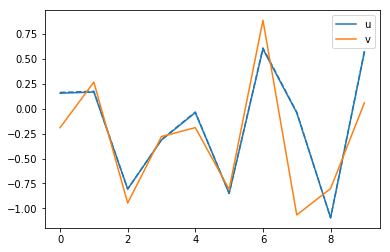

2 cannonical variates pair
prev corrcoef:
0.0070    0.0117    
0.0086    0.0147    
corrcoef: 0.8779


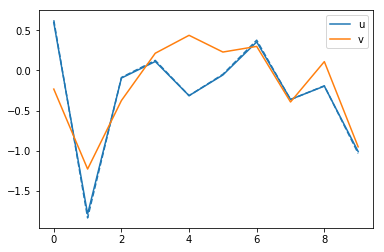

3 cannonical variates pair
prev corrcoef:
0.0299    0.0216    
0.0189    0.0179    
corrcoef: 0.8489


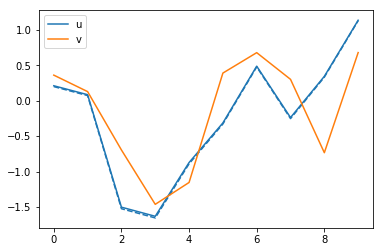

In [308]:
cca_info(X,Y,*sklearn_cca(X,Y))

1 cannonical variates pair
corrcoef: 0.9219


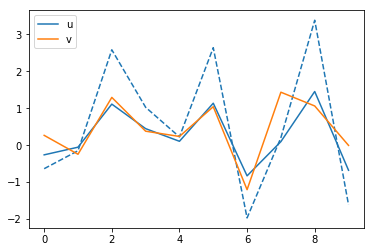

In [304]:
cca_info(X,Y,*calc_cca_adv(X,Y))

1 cannonical variates pair
corrcoef: 0.9221


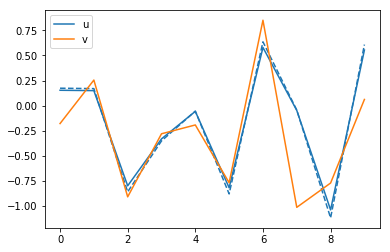

2 cannonical variates pair
prev corrcoef:
-0.0000   -0.0000   
0.0000    0.0000    
corrcoef: 0.8780


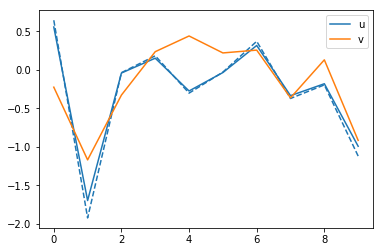

3 cannonical variates pair
prev corrcoef:
0.0000    0.0000    
-0.0000   -0.0000   
corrcoef: 0.8490


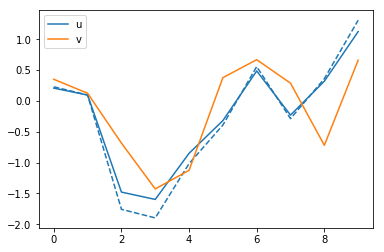

In [608]:
cca_info(X,Y,*calc_cca_2(X,Y))

3
1


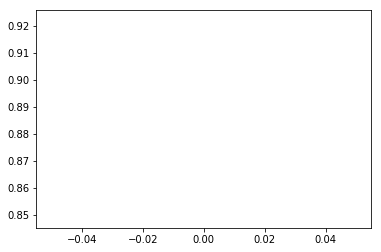



SKLEARN
1 cannonical variates pair
corrcoef: 0.9199


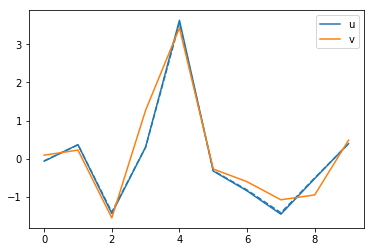

2 cannonical variates pair
prev corrcoef:
0.0838    0.0279    
0.1221    0.0666    
corrcoef: 0.8992


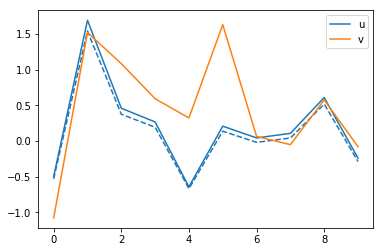

3 cannonical variates pair
prev corrcoef:
-0.0730   -0.0163   
-0.0864   -0.0366   
corrcoef: 0.8954


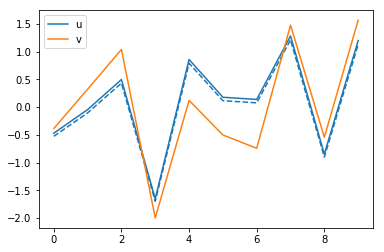

My method 3
1 cannonical variates pair
corrcoef: -0.9189


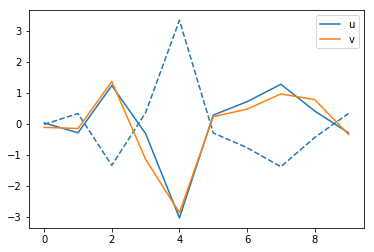

2 cannonical variates pair
prev corrcoef:
0.0999    -0.0369   
-0.1294   0.0661    
corrcoef: -0.8992


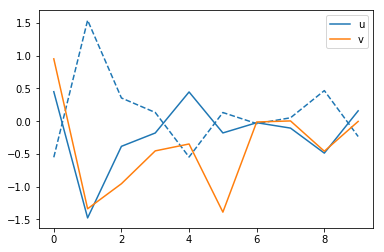

3 cannonical variates pair
prev corrcoef:
-0.0096   -0.0440   
0.0207    0.0409    
corrcoef: -0.8955


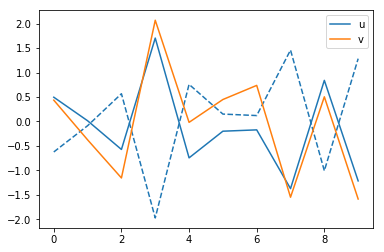

In [828]:
X,Y = gen_samples(100)

# print("My method")
# cca_info(X,Y,*calc_cca(X,Y))

# print("My method 2")
# cca_info(X,Y,*calc_cca_2(X,Y))

print("\n\nSKLEARN")
cca_info(X,Y,*sklearn_cca(nastyX,nastyY))

print("My method 3")
cca_info(X,Y,*calc_cca_3(nastyX,nastyY))

In [111]:
cca = CCA(n_components=3)
cca.fit(X,Y)

a = cca.x_rotations_
b = cca.y_rotations_

In [147]:
# Test cca


In [11]:
def calc_cca_2(x,y):
    x_sum = np.sum(x,axis=0)[:,np.newaxis]
    y_sum = np.sum(y,axis=0)[:,np.newaxis]
    xy_sum = np.matmul(np.transpose(x),y)
    xx_sum = np.matmul(np.transpose(x),x)
    yy_sum = np.matmul(np.transpose(y),y)
    n = np.shape(x)[0]

    xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
    xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
    yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)

    a_mat = np.matmul( np.matmul( np.matmul( np.linalg.inv(xx_cov), xy_cov ), np.linalg.inv(yy_cov)), xy_cov.T )
    
    a_eigvals, a_eigvecs = np.linalg.eig(a_mat)
    sorted_ids = sorted([i for i in range(len(a_eigvals))], key=lambda x: -a_eigvals[x])
    a_eigvals = a_eigvals
    a_eigvecs = a_eigvecs
    
    a = a_eigvecs.T #np.linalg.eigvals( a_mat )[:,np.newaxis]
    b = np.matmul(np.matmul( np.linalg.inv(yy_cov), xy_cov.T ),a )

    return (a,b)


1 cannonical variates pair
corrcoef: 0.9254


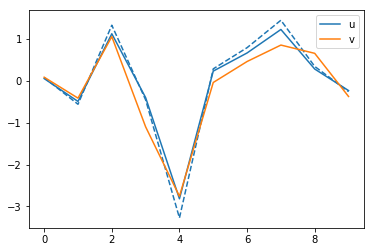

2 cannonical variates pair
prev corrcoef:
0.0020    0.0014    
0.0015    0.0016    
corrcoef: 0.9012


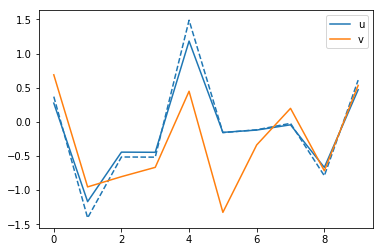

3 cannonical variates pair
prev corrcoef:
-0.0841   -0.0742   
-0.0747   -0.0829   
corrcoef: 0.8951


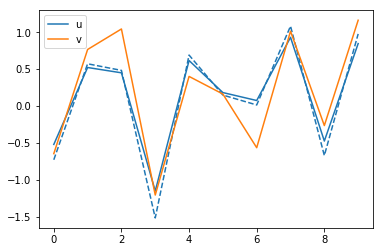

In [835]:
cca_info(X,Y,*calc_cca_2(X,Y))

In [1]:
def calc_cca_3(x,y):
    x_sum = np.sum(x,axis=0)[:,np.newaxis]
    y_sum = np.sum(y,axis=0)[:,np.newaxis]
    xy_sum = np.matmul(np.transpose(x),y)
    xx_sum = np.matmul(np.transpose(x),x)
    yy_sum = np.matmul(np.transpose(y),y)
    n = np.shape(x)[0]

    xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
    xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
    yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)


    xx_cov_sqrt_inv = np.linalg.inv( sqrtm(xx_cov) )
    yy_cov_sqrt_inv = np.linalg.inv( sqrtm(yy_cov) )
    
    u_mat = xx_cov_sqrt_inv @ xy_cov @ np.linalg.inv(yy_cov) @ xy_cov.T @ xx_cov_sqrt_inv
    u_eigvals,u_eigvecs = np.linalg.eig(u_mat)

    # Sort eigenvectors by their eigenvalues
    # The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
    u = u_eigvecs.T[sorted([i for i in range(len(u_eigvals))], key=lambda x: -u_eigvals[x])]

    v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
    v_eigvals,v_eigvecs = np.linalg.eig(v_mat)
    
    # Sort eigenvectors by their eigenvalues
    # The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
    v = v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

    a = (u @ xx_cov_sqrt_inv).T
    b = (v @ yy_cov_sqrt_inv).T

    return (a,b)

In [713]:
calc_cca_3(x,y)

(array([[-0.5793498 ,  0.26501726,  0.84039298],
        [ 0.50823267, -0.62667733,  0.75747573],
        [ 0.68185794,  0.80111945,  0.17281476]]),
 array([[-0.53498851,  0.23948366,  0.74913376],
        [ 0.51159629, -0.60433514,  0.57032889],
        [ 0.60534383,  0.69063388,  0.25671453]]))

In [706]:
calc_cca_2(x,y)

(array([[-0.56301261,  0.66263011,  0.49390093],
        [ 0.73428424,  0.15099502,  0.6618362 ],
        [ 0.25214012,  0.76219321, -0.5962272 ]]),
 array([[-0.47690376,  0.50029887,  0.38446787],
        [ 0.64916776,  0.02838658,  0.45798806],
        [ 0.23106107,  0.64134287, -0.41417978]]))

In [707]:
calc_cca_2(x,y)

(array([[-0.56301261,  0.66263011,  0.49390093],
        [ 0.73428424,  0.15099502,  0.6618362 ],
        [ 0.25214012,  0.76219321, -0.5962272 ]]),
 array([[-0.47690376,  0.50029887,  0.38446787],
        [ 0.64916776,  0.02838658,  0.45798806],
        [ 0.23106107,  0.64134287, -0.41417978]]))

In [666]:
a,b = calc_cca_2(x,y)
print( np.corrcoef( np.dot(x,a.T[0]), np.dot(y,b.T[0]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(x,a.T[1]), np.dot(y,b.T[1]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(x,a.T[2]), np.dot(y,b.T[2]),rowvar=False )[0,1] )
print()
print( np.corrcoef( np.dot(x,a.T[0]), np.dot(x,a.T[1]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(x,a.T[1]), np.dot(x,a.T[2]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(y,b.T[0]), np.dot(y,b.T[1]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(y,b.T[1]), np.dot(y,b.T[2]),rowvar=False )[0,1] )

[ 0.85034433  0.72080782  0.7708075 ]
0.858272378005


IndexError: index 1 is out of bounds for axis 0 with size 1

In [826]:
a,b = sklearn_cca(x,y,n_components=3)
print( np.corrcoef( np.dot(x,a.T[0]), np.dot(y,b.T[0]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(x,a.T[1]), np.dot(y,b.T[1]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(x,a.T[2]), np.dot(y,b.T[2]),rowvar=False )[0,1] )
print()
print( np.corrcoef( np.dot(x,a.T[0]), np.dot(x,a.T[1]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(x,a.T[1]), np.dot(x,a.T[2]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(y,b.T[0]), np.dot(y,b.T[1]),rowvar=False )[0,1] )
print( np.corrcoef( np.dot(y,b.T[1]), np.dot(y,b.T[2]),rowvar=False )[0,1] )

0.922083998705
0.877939001259
0.848914335497

0.00703482491595
0.029861802315
0.0147176606449
0.0178586098884


# Generate code for Mathematica

In [98]:
import itertools

def gen_matrix(matrix_name,matrix_height,matrix_width):
    
    elem_format = '{0}{1}{2}'
    if matrix_width == 1 and matrix_height > 1:
        elem_format = '{0}{1}'
    if matrix_height == 1 and matrix_width > 1:
        elem_format = '{0}{2}'
    
    print( 
        '{} = {{\n{}}};'.format(matrix_name,
        ',\n'.join( 
            [ '{{{}}}'.format( 
                ', '.join( [elem_format.format(matrix_name,i,j) 
                                          for j in range(matrix_width)] ) )
             for i in range(matrix_height) ]
        ) )
    )

In [121]:
def symbolic_covariance(name,xy_sum,x_sum,y_sum,n):
    print('{0} = ExpandAll[FullSimplify[({1} - {2}.Transpose[{3}]/{4})/({4} - 1)]];'.format(name,xy_sum,x_sum,y_sum,n))

n = 10
n_bands = 3

gen_matrix('xsum',n_bands,1)
gen_matrix('ysum',n_bands,1)

gen_matrix('xysum',n_bands,n_bands)
gen_matrix('xxsum',n_bands,n_bands)
gen_matrix('yysum',n_bands,n_bands)

symbolic_covariance('xycov','xysum','xsum','ysum','n')
symbolic_covariance('xxcov','xxsum','xsum','xsum','n')
symbolic_covariance('yycov','yysum','ysum','ysum','n')

gen_matrix('xxcovsqrt')

# xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
# xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
# yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)
# gen_matrix('xxcov',n_bands,n_bands)
# gen_matrix('yycov',n_bands,n_bands)
# gen_matrix('xycov',n_bands,n_bands)


#     x_sum = np.sum(x,axis=0)[:,np.newaxis]
#     y_sum = np.sum(y,axis=0)[:,np.newaxis]
#     xy_sum = np.matmul(np.transpose(x),y)
#     xx_sum = np.matmul(np.transpose(x),x)
#     yy_sum = np.matmul(np.transpose(y),y)
#     n = np.shape(x)[0]

xsum = {
{xsum0},
{xsum1},
{xsum2}};
ysum = {
{ysum0},
{ysum1},
{ysum2}};
xysum = {
{xysum00, xysum01, xysum02},
{xysum10, xysum11, xysum12},
{xysum20, xysum21, xysum22}};
xxsum = {
{xxsum00, xxsum01, xxsum02},
{xxsum10, xxsum11, xxsum12},
{xxsum20, xxsum21, xxsum22}};
yysum = {
{yysum00, yysum01, yysum02},
{yysum10, yysum11, yysum12},
{yysum20, yysum21, yysum22}};
xycov = ExpandAll[FullSimplify[(xysum - xsum.Transpose[ysum]/n)/(n - 1)]];
xxcov = ExpandAll[FullSimplify[(xxsum - xsum.Transpose[xsum]/n)/(n - 1)]];
yycov = ExpandAll[FullSimplify[(yysum - ysum.Transpose[ysum]/n)/(n - 1)]];


# Sample

In [114]:
x_sum

array([[-9.39153906],
       [ 1.02360145],
       [ 2.57156831]])

In [115]:
y_sum

array([[-7.82761079],
       [-6.22984367],
       [ 3.32493778]])

In [116]:
np.matmul(x_sum,y_sum.T)

array([[ 73.51331249,  58.50782017, -31.22628299],
       [ -8.01235377,  -6.37687702,   3.40341113],
       [-20.12923589, -16.02046859,   8.55030463]])

In [264]:
# Correlation function
def calc_covariance(xy_sum,x_sum,y_sum,n):
    """
    calculate covariance matrix of 2 variables
    """
    return ( xy_sum - np.matmul(x_sum,y_sum.T)/n )/(n-1)

x = np.array(nastyX)
y = np.array(nastyY)

x_sum = np.sum(x,axis=0)[:,np.newaxis]
y_sum = np.sum(y,axis=0)[:,np.newaxis]
xy_sum = np.matmul(np.transpose(x),y)
xx_sum = np.matmul(np.transpose(x),x)
yy_sum = np.matmul(np.transpose(y),y)
n = np.shape(x)[0]

xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)


xx_cov_sqrt_inv = np.linalg.inv( sqrtm(xx_cov) )
yy_cov_sqrt_inv = np.linalg.inv( sqrtm(yy_cov) )

u_mat = xx_cov_sqrt_inv @ xy_cov @ np.linalg.inv(yy_cov) @ xy_cov.T @ xx_cov_sqrt_inv
u_eigvals,u_eigvecs = np.linalg.eig(u_mat)

# Sort eigenvectors by their eigenvalues
# The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
u = u_eigvecs.T[sorted([i for i in range(len(u_eigvals))], key=lambda x: -u_eigvals[x])]

v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

# Sort eigenvectors by their eigenvalues
# The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
v = v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

a = (u @ xx_cov_sqrt_inv).T
b = (v @ yy_cov_sqrt_inv).T

In [245]:
test_mat = np.array([[0.5,2],[0.5,1]])
test_eig = np.linalg.eig(test_mat)[1][:,0]
np.matmul( test_mat, test_eig )/test_eig

array([-0.28077641, -0.28077641])

In [241]:
np.linalg.eig(test_mat)[0]

array([-0.28077641,  1.78077641])

In [194]:
u_eigvecs[0]

array([-0.12906273, -0.76509306,  0.63085293])

1 cannonical variates pair
corrcoef: 0.9497


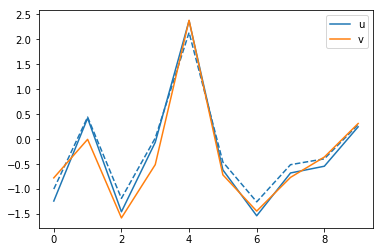

2 cannonical variates pair
prev corrcoef:
-0.1987   -0.1363   
-0.1827   -0.1391   
corrcoef: 0.9318


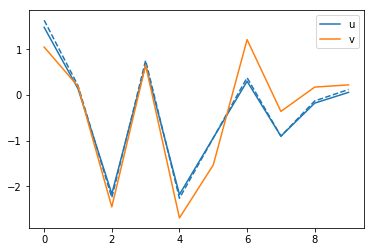

3 cannonical variates pair
prev corrcoef:
-0.1216   -0.0903   
-0.1332   -0.1098   
corrcoef: 0.6871


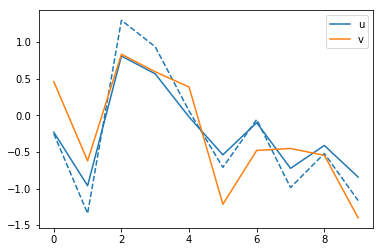

In [271]:
cca_info(nastyX,nastyY,a,b)

In [270]:
a,b = sklearn_cca(nastyX,nastyY)